In [ ]:
!apt-get update
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-2.3.1/spark-2.3.1-bin-hadoop2.7.tgz
!tar xf spark-2.3.1-bin-hadoop2.7.tgz
!pip install -q findspark

import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.3.1-bin-hadoop2.7"

import findspark
findspark.init()

import pyspark

# SparkContext
from pyspark import SparkConf, SparkContext
conf = SparkConf().setMaster("local").setAppName("My App")
sc = SparkContext(conf=conf)

# SparkSession
from pyspark.sql import SparkSession

#spark = SparkSession.builder.getOrCreate() 
spark = SparkSession.builder.appName("My App").getOrCreate()
spark

Get:1 http://security.ubuntu.com/ubuntu bionic-security InRelease [88.7 kB]
Get:2 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease [3,626 B]
Ign:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Get:4 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease [15.9 kB]
Ign:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Get:6 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release [697 B]
Hit:7 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Get:8 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release.gpg [836 B]
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Get:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease [88.7 kB]
Hit:11 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Get:12 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu 

# Prepare and understand data for modeling

### Duplicates

Consider the following example.

In [ ]:
df = spark.createDataFrame([
        (1, 144.5, 5.9, 33, 'M'),
        (2, 167.2, 5.4, 45, 'M'),
        (3, 124.1, 5.2, 23, 'F'),
        (4, 144.5, 5.9, 33, 'M'),
        (5, 133.2, 5.7, 54, 'F'),
        (3, 124.1, 5.2, 23, 'F'),
        (5, 129.2, 5.3, 42, 'M'),
    ], ['id', 'weight', 'height', 'age', 'gender'])

Check for duplicates.

In [ ]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 7
Count of distinct rows: 6


この2つの数値が異なる場合、お互いに完全なコピーである行があることになります。これらの行を削除するには、`.dropDuplicates(...)`メソッドを使用します。

In [ ]:
df = df.dropDuplicates()
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  5| 129.2|   5.3| 42|     M|
|  1| 144.5|   5.9| 33|     M|
|  4| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
+---+------+------+---+------+



Let's confirm.

In [ ]:
print('Count of ids: {0}'.format(df.count()))
print('Count of distinct ids: {0}'.format(df.select([c for c in df.columns if c != 'id']).distinct().count()))

Count of ids: 6
Count of distinct ids: 5


まだ1つ重複しています。`.dropDuplicates(...)`を使用しますが、subsetパラメータを追加します。

In [ ]:
df = df.dropDuplicates(subset=[c for c in df.columns if c != 'id']) # id以外のカラム指定
df.show()

+---+------+------+---+------+
| id|weight|height|age|gender|
+---+------+------+---+------+
|  5| 133.2|   5.7| 54|     F|
|  1| 144.5|   5.9| 33|     M|
|  2| 167.2|   5.4| 45|     M|
|  3| 124.1|   5.2| 23|     F|
|  5| 129.2|   5.3| 42|     M|
+---+------+------+---+------+



IDの総数と識別番号を一度に計算するには、`.agg(...)`メソッドを使用します。

In [ ]:
import pyspark.sql.functions as fn

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+-----+--------+
|count|distinct|
+-----+--------+
|    5|       4|
+-----+--------+



Give each row a unique ID. 

In [ ]:
df.withColumn('new_id', fn.monotonically_increasing_id()).show()

+---+------+------+---+------+-------------+
| id|weight|height|age|gender|       new_id|
+---+------+------+---+------+-------------+
|  5| 133.2|   5.7| 54|     F|  25769803776|
|  1| 144.5|   5.9| 33|     M| 171798691840|
|  2| 167.2|   5.4| 45|     M| 592705486848|
|  3| 124.1|   5.2| 23|     F|1236950581248|
|  5| 129.2|   5.3| 42|     M|1365799600128|
+---+------+------+---+------+-------------+



### Missing observations

上で紹介したのと似たような例を考えてみましょう。

In [ ]:
df_miss = spark.createDataFrame([
        (1, 143.5, 5.6, 28,   'M',  100000),
        (2, 167.2, 5.4, 45,   'M',  None),
        (3, None , 5.2, None, None, None),
        (4, 144.5, 5.9, 33,   'M',  None),
        (5, 133.2, 5.7, 54,   'F',  None),
        (6, 124.1, 5.2, None, 'F',  None),
        (7, 129.2, 5.3, 42,   'M',  76000),
    ], ['id', 'weight', 'height', 'age', 'gender', 'income'])

行ごとの欠落値の数を求めるには、以下のsnippetを使用します。

In [ ]:
df_miss.rdd.map(
    lambda row: (row['id'], sum([c == None for c in row]))
).collect()

[(1, 0), (2, 1), (3, 4), (4, 1), (5, 1), (6, 2), (7, 0)]

どのような値が欠落しているかを見てみましょう。そうすれば、欠落値を数えるときに、その欠損値を完全に削除するか、あるいは欠損値埋めするかを決めることができます。

In [ ]:
df_miss.where('id == 3').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  3|  null|   5.2|null|  null|  null|
+---+------+------+----+------+------+



各列に見られる欠損箇所の割合はいくつですか？

In [ ]:
# * で全選択できる

df_miss.select('*').show()

+---+------+------+----+------+------+
| id|weight|height| age|gender|income|
+---+------+------+----+------+------+
|  1| 143.5|   5.6|  28|     M|100000|
|  2| 167.2|   5.4|  45|     M|  null|
|  3|  null|   5.2|null|  null|  null|
|  4| 144.5|   5.9|  33|     M|  null|
|  5| 133.2|   5.7|  54|     F|  null|
|  6| 124.1|   5.2|null|     F|  null|
|  7| 129.2|   5.3|  42|     M| 76000|
+---+------+------+----+------+------+



In [ ]:
df_miss.agg(fn.count('*')).show()

+--------+
|count(1)|
+--------+
|       7|
+--------+



In [ ]:
df_miss.agg(*[ # リスト宣言前の'*'は.agg(...)メソッドに対して渡されry個別のパラメータ集合としてリストを扱うように指示
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df_miss.columns
]).show()

+----------+------------------+--------------+------------------+------------------+------------------+
|id_missing|    weight_missing|height_missing|       age_missing|    gender_missing|    income_missing|
+----------+------------------+--------------+------------------+------------------+------------------+
|       0.0|0.1428571428571429|           0.0|0.2857142857142857|0.1428571428571429|0.7142857142857143|
+----------+------------------+--------------+------------------+------------------+------------------+



We will drop the `'income'` feature as most of its values are missing.

In [ ]:
df_miss_no_income = df_miss.select([c for c in df_miss.columns if c != 'income'])
df_miss_no_income.show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  3|  null|   5.2|null|  null|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



To drop the observations instead you can use the `.dropna(...)` method.

In [ ]:
df_miss_no_income.dropna(thresh=3).show()

+---+------+------+----+------+
| id|weight|height| age|gender|
+---+------+------+----+------+
|  1| 143.5|   5.6|  28|     M|
|  2| 167.2|   5.4|  45|     M|
|  4| 144.5|   5.9|  33|     M|
|  5| 133.2|   5.7|  54|     F|
|  6| 124.1|   5.2|null|     F|
|  7| 129.2|   5.3|  42|     M|
+---+------+------+----+------+



平均値や中央値などの計算値を入力するには、まずその値を計算し、そのような値を含むdictを作成して、それを`.fillna(...)`メソッドに渡す必要があります。

In [ ]:
means = df_miss_no_income.agg(
    *[fn.mean(c).alias(c) for c in df_miss_no_income.columns if c != 'gender']
).toPandas().to_dict('records')[0]

means['gender'] = 'missing'

df_miss_no_income.fillna(means).show()

+---+-------------+------+---+-------+
| id|       weight|height|age| gender|
+---+-------------+------+---+-------+
|  1|        143.5|   5.6| 28|      M|
|  2|        167.2|   5.4| 45|      M|
|  3|140.283333333|   5.2| 40|missing|
|  4|        144.5|   5.9| 33|      M|
|  5|        133.2|   5.7| 54|      F|
|  6|        124.1|   5.2| 40|      F|
|  7|        129.2|   5.3| 42|      M|
+---+-------------+------+---+-------+



### Outliers

Consider another simple example.

In [ ]:
df_outliers = spark.createDataFrame([
        (1, 143.5, 5.3, 28),
        (2, 154.2, 5.5, 45),
        (3, 342.3, 5.1, 99),
        (4, 144.5, 5.5, 33),
        (5, 133.2, 5.4, 54),
        (6, 124.1, 5.1, 21),
        (7, 129.2, 5.3, 42),
    ], ['id', 'weight', 'height', 'age'])

まず、各特徴量の下限カットオフポイントと上限カットオフポイントを算出します。

In [ ]:
cols = ['weight', 'height', 'age']
bounds = {}

for col in cols:
    quantiles = df_outliers.approxQuantile(col, [0.25, 0.75], 0.05)
    IQR = quantiles[1] - quantiles[0]
    bounds[col] = [quantiles[0] - 1.5 * IQR, quantiles[1] + 1.5 * IQR]

`bounds`辞書には，各フィーチャーの下限値と上限値が格納されています．

In [ ]:
bounds

{'age': [-11.0, 93.0],
 'height': [4.499999999999999, 6.1000000000000005],
 'weight': [91.69999999999999, 191.7]}

これを使って外れ値のフラグを立ててみましょう。

In [ ]:
outliers = df_outliers.select(*['id'] + [
    (
        (df_outliers[c] < bounds[c][0]) | 
        (df_outliers[c] > bounds[c][1])
    ).alias(c + '_o') for c in cols
])
outliers.show()

+---+--------+--------+-----+
| id|weight_o|height_o|age_o|
+---+--------+--------+-----+
|  1|   false|   false|false|
|  2|   false|   false|false|
|  3|    true|   false| true|
|  4|   false|   false|false|
|  5|   false|   false|false|
|  6|   false|   false|false|
|  7|   false|   false|false|
+---+--------+--------+-----+



`height`の特徴では2つ、`age`の特徴では2つの外れ値があります。

In [ ]:
df_outliers = df_outliers.join(outliers, on='id')
df_outliers.filter('weight_o').select('id', 'weight').show()
df_outliers.filter('age_o').select('id', 'age').show()

+---+------+
| id|weight|
+---+------+
|  3| 342.3|
+---+------+

+---+---+
| id|age|
+---+---+
|  3| 99|
+---+---+



## Understand your data

### Descriptive statistics

Load our data and convert it to a Spark DataFrame.

In [ ]:
import pyspark.sql.types as typ

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Next, we read the data in.

In [ ]:
fraud = sc.textFile('/content/drive/MyDrive/Colab Notebooks/data/ccFraud.csv.gz')
header = fraud.first()

fraud = fraud \
    .filter(lambda row: row != header) \
    .map(lambda row: [int(elem) for elem in row.split(',')])

続いて、`DataFrame`のスキーマを作成します。

In [ ]:
fields = [
    *[
        typ.StructField(h[1:-1], typ.IntegerType(), True)
        for h in header.split(',')
    ]
]

schema = typ.StructType(fields)

最後に、`DataFrame`を作成します。

In [ ]:
fraud_df = spark.createDataFrame(fraud, schema)

In [ ]:
fraud_df.count()

10000000

データフレームの準備ができたので、データセットの基本的な記述統計を計算することができます。

In [ ]:
fraud_df.printSchema()

root
 |-- custID: integer (nullable = true)
 |-- gender: integer (nullable = true)
 |-- state: integer (nullable = true)
 |-- cardholder: integer (nullable = true)
 |-- balance: integer (nullable = true)
 |-- numTrans: integer (nullable = true)
 |-- numIntlTrans: integer (nullable = true)
 |-- creditLine: integer (nullable = true)
 |-- fraudRisk: integer (nullable = true)



カテゴリカルな列については、`.groupby(...)`メソッドを使って値の頻度を数えます。

In [ ]:
fraud_df.groupby('gender').count().show()

+------+-------+
|gender|  count|
+------+-------+
|     1|6178231|
|     2|3821769|
+------+-------+



数値的な機能については、`.describe()`メソッドを使うことができます。

In [ ]:
numerical = ['balance', 'numTrans', 'numIntlTrans']

In [ ]:
desc = fraud_df.describe(numerical)
desc.show()

+-------+-----------------+------------------+-----------------+
|summary|          balance|          numTrans|     numIntlTrans|
+-------+-----------------+------------------+-----------------+
|  count|         10000000|          10000000|         10000000|
|   mean|     4109.9199193|        28.9351871|        4.0471899|
| stddev|3996.847309737077|26.553781024522852|8.602970115863767|
|    min|                0|                 0|                0|
|    max|            41485|               100|               60|
+-------+-----------------+------------------+-----------------+



ここでは、歪度をチェックする方法を紹介します（ここでは、「balance」のみで行います）。

In [ ]:
fraud_df.agg({'balance': 'skewness'}).show()

+------------------+
| skewness(balance)|
+------------------+
|1.1818315552995033|
+------------------+



### Correlations

データがDataFrame形式であれば、PySparkでの相関関係の計算は非常に簡単です。

In [ ]:
fraud_df.corr('balance', 'numTrans')

0.00044523140172659576

相関行列を作成するには、以下のスクリプトを使用します。

In [ ]:
n_numerical = len(numerical)

corr = []

for i in range(0, n_numerical):
    temp = [None] * i
    
    for j in range(i, n_numerical):
        temp.append(fraud_df.corr(numerical[i], numerical[j]))
    corr.append(temp)
    
corr

### Visualization

First, let's load the modules and set them up.

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

# import bokeh.charts as chrt
# from bokeh.io import output_notebook

# output_notebook()

### Histograms

ワーカーのデータを集計し、カットオフポイントとヒストグラムの各ビンのカウント数を集計したリストをドライバーに返す。

In [ ]:
hists = fraud_df.select('balance').rdd.flatMap(lambda row: row).histogram(20)

In [ ]:
hists

([0.0,
  2074.25,
  4148.5,
  6222.75,
  8297.0,
  10371.25,
  12445.5,
  14519.75,
  16594.0,
  18668.25,
  20742.5,
  22816.75,
  24891.0,
  26965.25,
  29039.5,
  31113.75,
  33188.0,
  35262.25,
  37336.5,
  39410.75,
  41485],
 [3640021,
  2258778,
  1718633,
  1035019,
  601524,
  343461,
  192766,
  104486,
  54517,
  27570,
  13117,
  5805,
  2650,
  1103,
  358,
  127,
  45,
  15,
  1,
  4])

To plot the histogram you can simply call the matplotlib like below.

Text(0.5, 1.0, "Histogram of 'balance'")

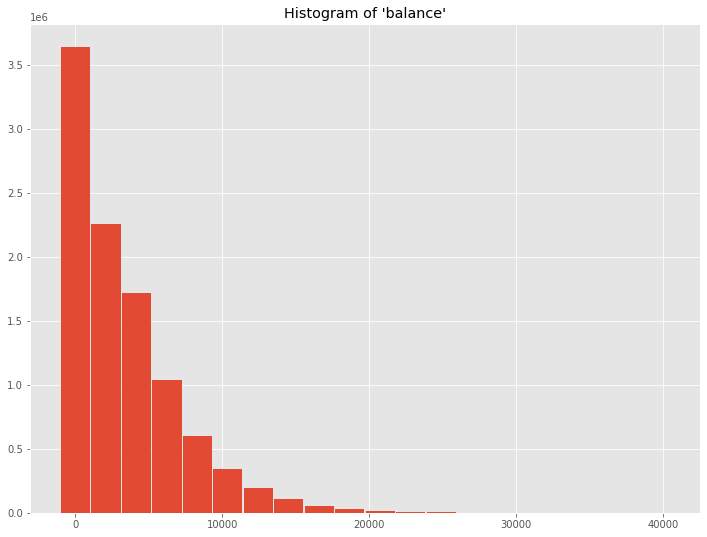

In [ ]:
data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}

fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)
ax.bar(data['bins'], data['freq'], width=2000)
ax.set_title('Histogram of \'balance\'')

# plt.savefig('B05793_05_22.png', dpi=300)

In a similar manner, a histogram can be create with Bokeh.

In [ ]:
# b_hist = chrt.Bar(data, values='freq', label='bins', title='Histogram of \'balance\'')
# chrt.show(b_hist)

AttributeError: ignored

データがドライバーに収まるほど小さい場合は（通常は上に示した方法を使った方が早いと思いますが）、データを持ってきて、`.hist(...)` (from Matplotlib)または.`Histogram(...)` (from Bokeh)メソッドを使うことができます。

In [ ]:
data_driver = {'obs': fraud_df.select('balance').rdd.flatMap(lambda row: row).collect()}

Text(0.5, 1.0, "Histogram of 'balance' using .hist()")

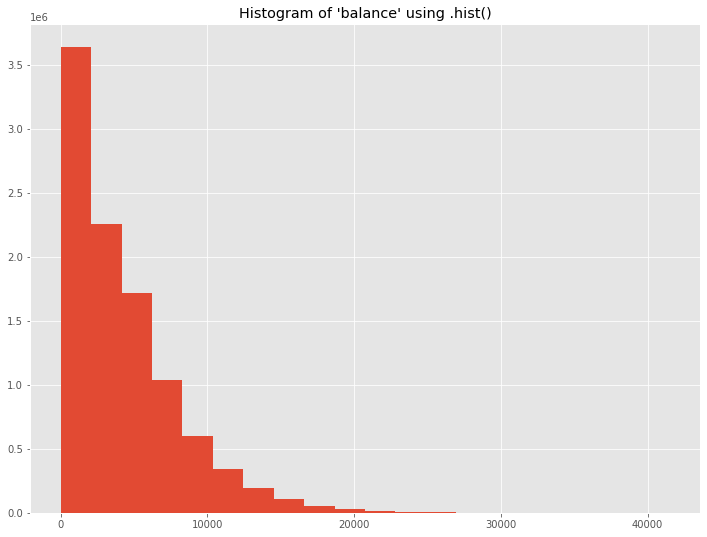

In [ ]:
fig = plt.figure(figsize=(12,9))
ax = fig.add_subplot(1, 1, 1)

ax.hist(data_driver['obs'], bins=20)
ax.set_title('Histogram of \'balance\' using .hist()')


# plt.savefig('B05793_05_24.png', dpi=300)

In [ ]:
# b_hist_driver = chrt.Histogram(data_driver, values='obs', title='Histogram of \'balance\' using .Histogram()', bins=20)
# chrt.show(b_hist_driver)

### Interactions between features

In this example we will sample our fraud dataset at 1% given gender as strata.
この例では、性別を層として与えられた1％の不正利用のデータセットをサンプリングします。

In [ ]:
data_sample = fraud_df.sampleBy('gender', {1: 0.0002, 2: 0.0002}).select(numerical)

To put multiple 2D charts in one go you can use

In [ ]:
# # import bokeh.charts as chrt

# data_multi = dict([
#     (elem, data_sample.select(elem).rdd.flatMap(lambda row: row).collect()) 
#     for elem in numerical
# ])

# sctr = chrt.Scatter(data_multi, x='balance', y='numTrans')

# chrt.show(sctr)